# Configuration speed visualization

by Huihan Liu, May 28 2019

When we implement high-performance GEMM (General Matrix Multiplication), we use cache blocking to divide matrices into small cache blocks (macro kernel), and within each cache block, we access smaller chunks sequentially in the innermost microkernel. To multiply C = A * B, where A is of size M * K and B is of size K * N, there can be different combinations of cache block size (MCB, NCB, KCB) and smaller chunk size (MR, NR). Our goal is to pick the best combinations of these parameters and find the configuration that has the fastest speed.

In this document, I will plot the runtime of different configurations of cache blocking parameters, and explore how different parameters can have an effect on the speedup.

Source code: https://github.com/huihanl/tvm/blob/tvm_quantization/tests/python/contrib/test_fbgemm_packed_weight_ex_search.py

## 1. Setup: Parsing the log file and building dataset

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

When TVM performs matrix multiplication, the configurations are recorded in a log file. The format of each row of the log file looks like this:

```python
{"i": ["llvm", "tune_fbgemm_packed_weights", [1, 4096, 1024], {}, ["tune_fbgemm_packed_weights", 1, 4096, 1024], {"i": 768, "c": null, "e": [["VAL_CNFG", "ot", [192, 16, 256, 24, 16, 16, 4]]], "t": ""}], "r": [[0.00041945070000000005], 0, 4.6792261600494385, 1558933943.442328], "v": 0.1}
```

Where ```[192, 16, 256, 24, 16, 16, 4] ``` represents the set of configurations, i.e. the value of MCB, NCB, KCB, MR, NR, NR_MIN, and ROW_INTERLEAVE; ```[0.00041945070000000005]``` represents the time taken to run the program under that specific configuration.


We will go on to parse the configuration list and runtime, and store them in ```new_config_lst``` and ```new_runtime_lst```:

In [132]:
filepath = "fbgemm_results_1_4096_1024.log"  
config_lst = []
runtime_lst = []
with open(filepath) as fp:
    for _, line in enumerate(fp):
        line = line.replace("null", "None")
        line = eval(line)
        config = line["i"][5]["e"][0][2]
        runtime = line["r"][0][0]
        config_lst.append(config)
        runtime_lst.append(runtime)

In [133]:
# clean bad data
new_config_lst = []
new_runtime_lst = []
for i in range(len(config_lst)):
    if runtime_lst[i] <= 1:
        new_config_lst.append(config_lst[i])
        new_runtime_lst.append(runtime_lst[i])

In evaluation of performance, we use GOPS (Giga Operations Per Second), which is calculated by number of operations / runtime. The number of operations of matrix multiplication C = A * B is estimated by 2 * m * n * k, because for each entry (i, j) in C, we need k multication and k addition, and we have m * n such entries. 

In [134]:
import math
m, n, k = (1, 4096, 1024)
no_ops = 2 * m * n * k
Gops_lst = [no_ops / r / math.pow(10, 9) for r in new_runtime_lst]

To make plotting and analysiing more convenient, we store the configuration data and runtime in a dataset, with column headers being ```mcb, ncb, kcb, mr, nr, Gops```. Also for convenience, we will sort each data point by Gops, from greatest to lowest. The dataset ```new_config_lst``` can be seen below:

In [135]:
new_config_str_lst = [str(i) for i in new_config_lst]
dictionary = dict(zip(new_config_str_lst, Gops_lst))
pair = sorted(dictionary.items(), key = lambda x : -x[1])
new_config_x = [eval(p[0]) for p in pair]
new_Gops_lst = [p[1] for p in pair]

In [136]:
new_config_lst = np.array(new_config_x)
new_config_lst = pd.DataFrame(new_config_lst, columns=["mcb", "ncb", "kcb", "mr", "nr", "16", "4"])
new_config_lst = new_config_lst.drop(["16", "4"], axis = 1)
new_config_lst["Gops"] = new_Gops_lst
new_config_lst.head()

,mcb,ncb,kcb,mr,nr,Gops
0,240,16,256,2,16,22.667288
1,192,32,512,2,32,22.346375
2,192,16,832,6,16,22.307737
3,240,16,1024,6,16,22.245185
4,240,16,512,4,16,22.162693


In [137]:
new_config_x_str = [p[0] for p in pair]
new_Gops_lst = [p[1] for p in pair]

## 2. Plotting change in Gops between different configurations

The first simple plot is to plot Gops against different kinds of configurations to get an idea of how the performance varies across different parameters. We have sorted our dataset according to Gops, so that we can first try to visualize the extent to which Gops decreases when we have a less optimized configuration. The plot can be seen below:

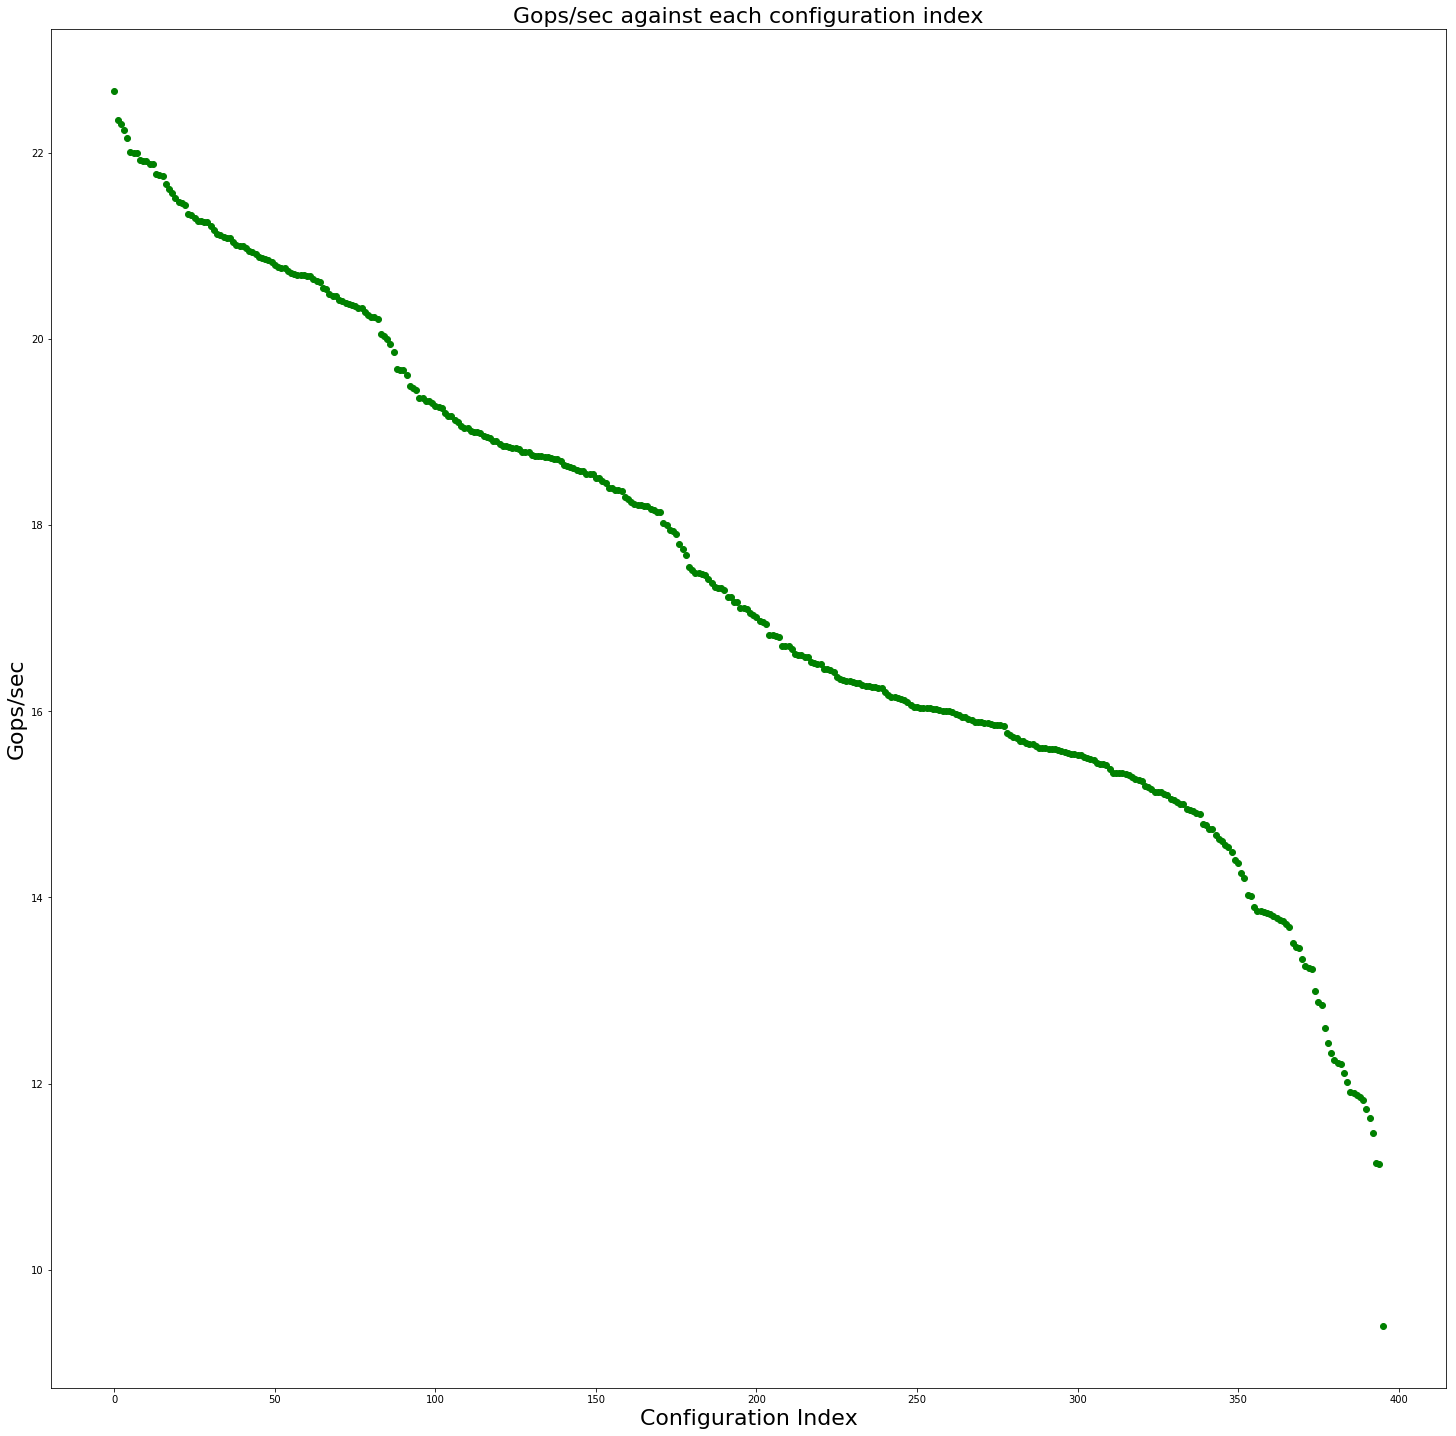

In [138]:
plt.figure(figsize=(25, 25))
plt.xlabel('Configuration Index', fontsize=22)
plt.ylabel('Gops/sec', fontsize=22)
plt.title("Gops/sec against each configuration index", fontsize=22)
plt.plot([i for i in range(len(new_config_x))], new_Gops_lst, 'go')

We can see that there are three distinct parts in the graph, where it first decreases linearly, and then decreases sharply, and afain decreases linearly, etc. This shows that in general when we change to a less optimized configuration, the performance get worse in a linear manner; but there are certain phase transitions where performance might drop sharply. This can be one area where we can explore more into later on.

## 3. The effect of one parameter

Also, we want to explore how might a single parameter among MCB, NCB, KCB, MR, NR affect the overall performance. Although the actual effect results from a combination of parameters, it might still be interesting to evaluate the change against one parameter because that can give us additional insight.

Below are results if we fix MR and NR, and see the effect of MCB/NCB/KCB on Gops. Using the subgraphs for MCB as an example: each graph represents the plot of Gops against MCB, for a certain fixed combination of MR and NR. Also, for a fixed value of MCB = ```x```, the different dots represent all the data points that have MCB set to ```x```, but whose value of NCB, MCB vary.

Here are some of the interesting results we get for MCB, NCB and KCB:

- MCB: We can see from the graph that, for most (MR, NR) pair, for the different value of MCB, the distribution of dots across that vertical line are quite similar. This can imply that the choice MCB does not have a signicant result on performance, which instead depends on the choice of NCB and KCB.

- NCB: For different values of NCB, the resulting distribution of data points vary significantly. For example, there are often an entire shift from a distritution of higher Gops to lower Gops, if we change NCB (e.g. check MR=8, NR=16). This can possibly show that NCB is one deciding factor.

- KCB: KCB is definitely a deciding factor because the resulting distribution varies quite randomly, but for each KCB value, the set of valid configuration is small in the first place. Therefore we cannot deduct direct influence of KCB from the graphs, although we can conclude its joint influence with other factors.

In [139]:
# function that do selecting and plotting
def plot_fix_mr_nr_effectof(mr, nr, fac):
    plt.figure(figsize=(5, 4))
    df = new_config_lst
    df = df.loc[(df['mr'] == mr) & (df['nr'] == nr)]
    plt.title('Plot of Gops against {}, MR={}, NR={}'.format(fac, mr, nr))
    plt.xlabel(fac)
    plt.ylabel("Gops")
    plt.plot(df[fac], df["Gops"], "go")


#### 1) MCB

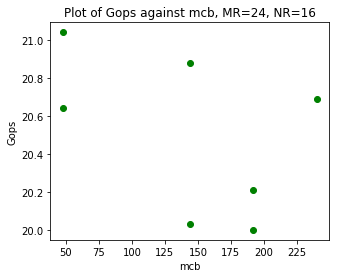

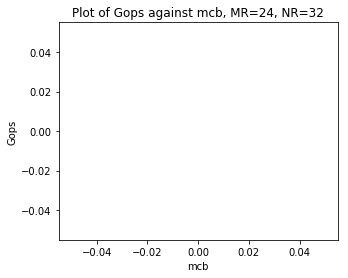

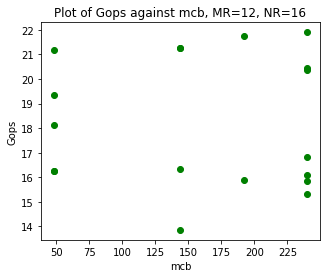

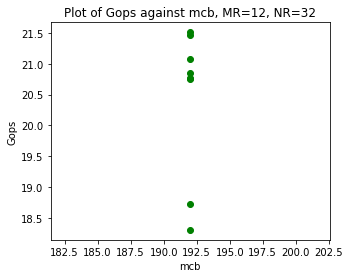

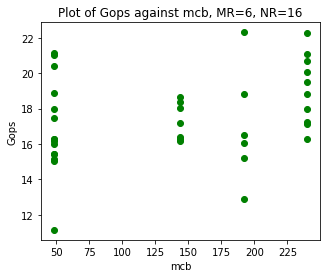

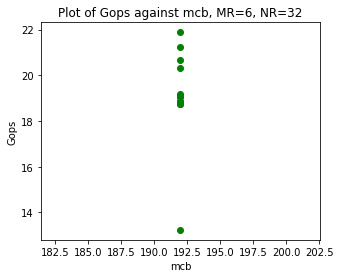

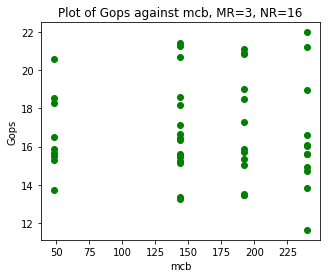

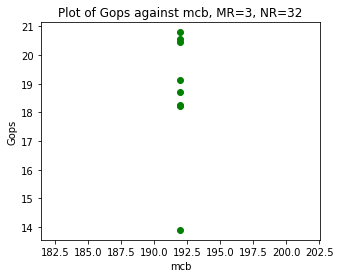

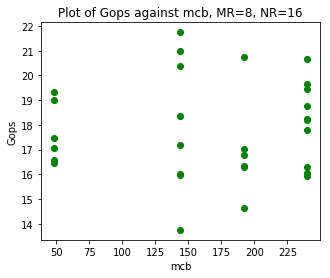

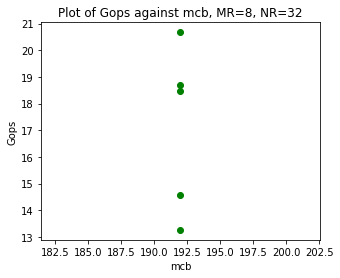

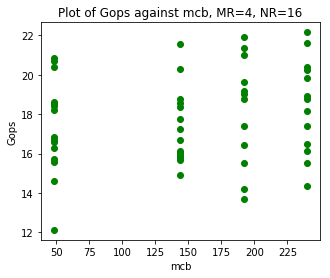

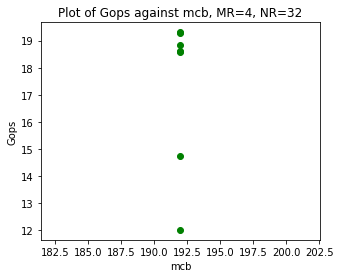

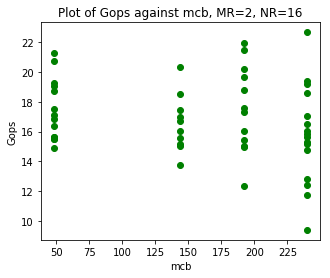

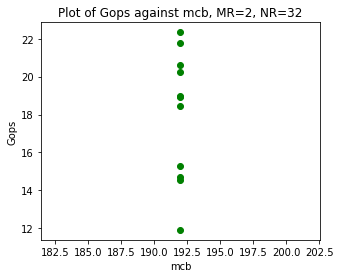

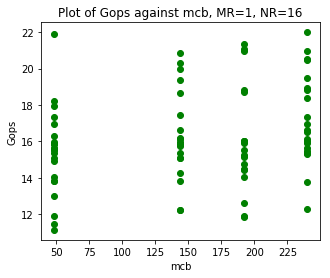

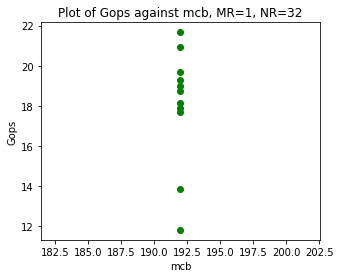

In [140]:
MRs = [24, 12, 6, 3, 8, 4, 2, 1]
NRs = [16, 32]

for mr in MRs:
    for nr in NRs:
        plot_fix_mr_nr_effectof(mr, nr, "mcb")

#### 2) NCB

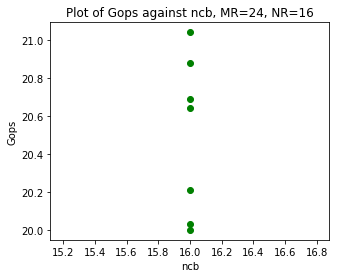

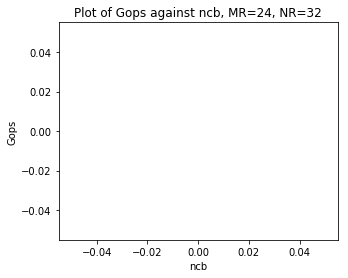

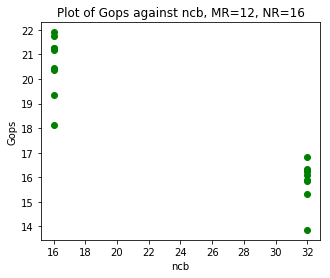

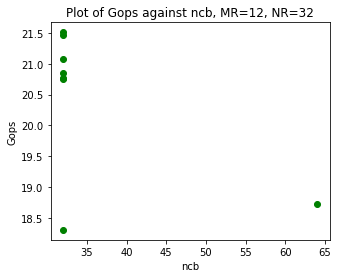

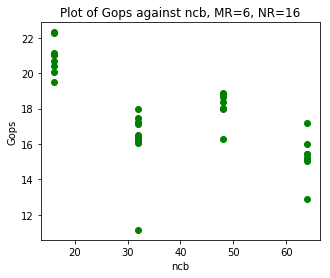

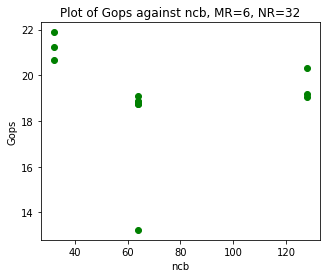

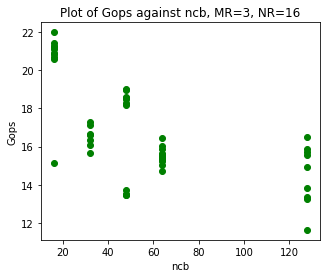

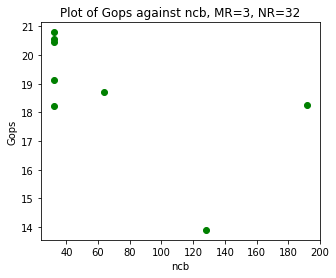

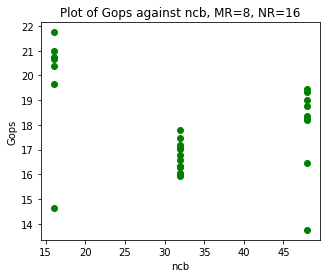

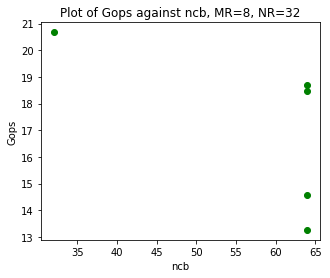

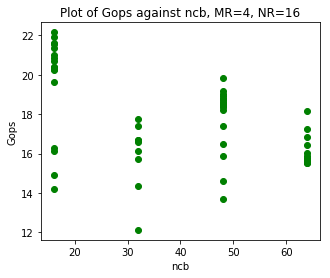

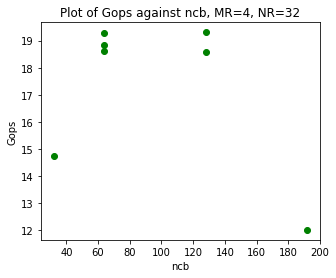

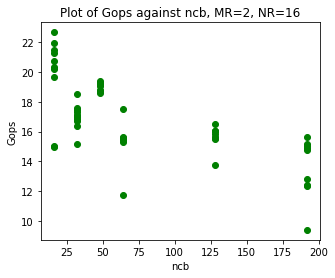

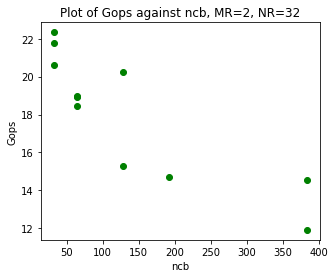

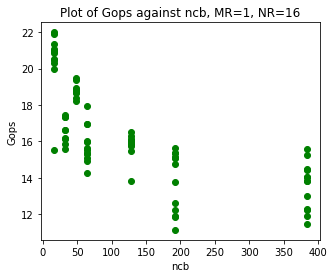

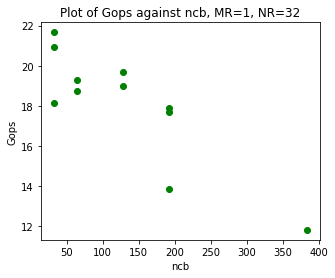

In [141]:
MRs = [24, 12, 6, 3, 8, 4, 2, 1]
NRs = [16, 32]

for mr in MRs:
    for nr in NRs:
        plot_fix_mr_nr_effectof(mr, nr, "ncb")

#### 3) KCB

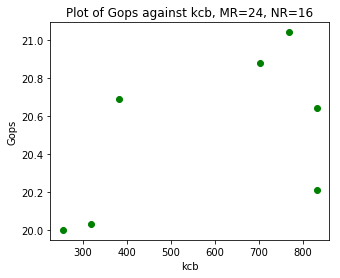

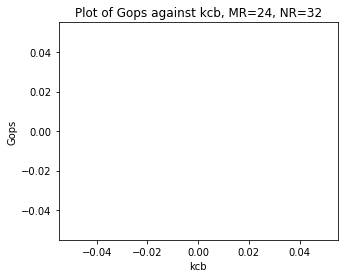

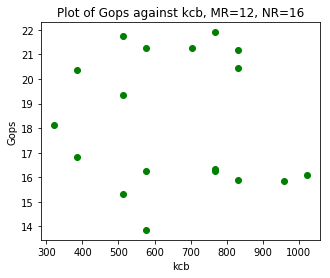

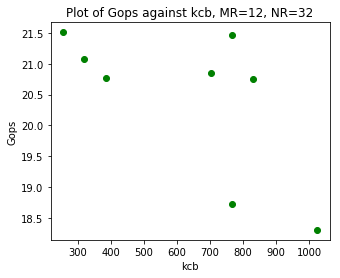

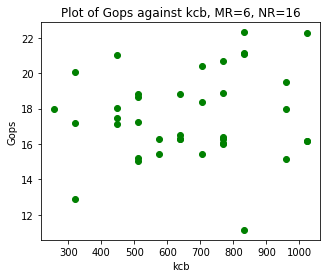

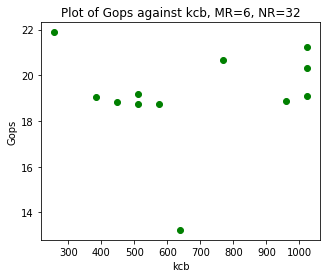

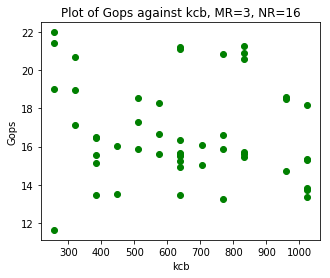

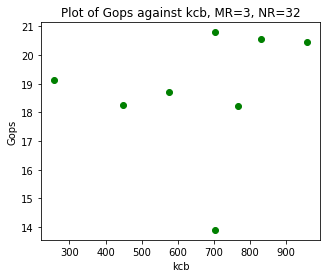

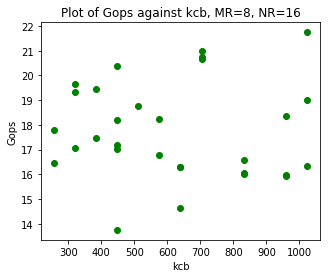

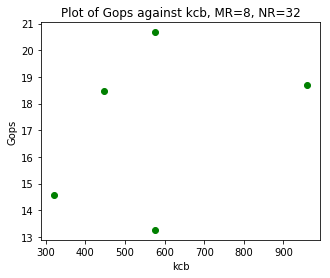

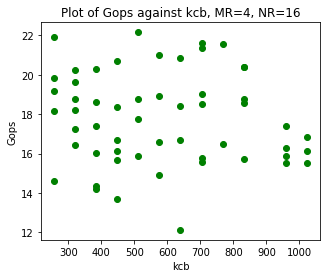

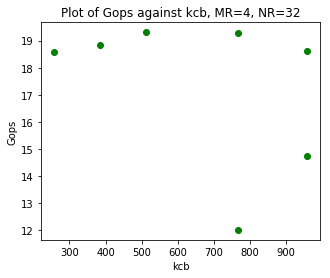

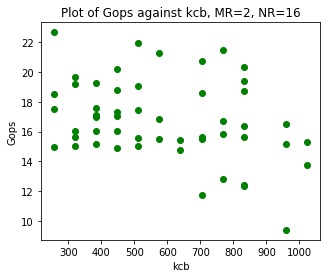

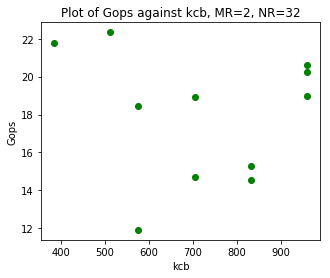

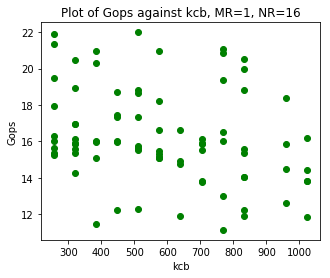

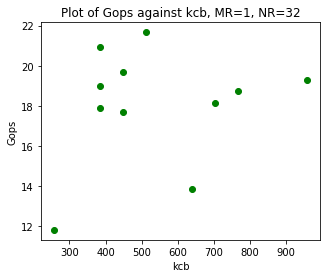

In [142]:
MRs = [24, 12, 6, 3, 8, 4, 2, 1]
NRs = [16, 32]

for mr in MRs:
    for nr in NRs:
        plot_fix_mr_nr_effectof(mr, nr, "kcb")

Similarly, we can fix MCB and NCB and evaluate how KCB affects performance:

In [143]:
def plot_fix_mcb_ncb_kcb_effectof(mcb, ncb):
    plt.figure(figsize=(5, 4))
    df = new_config_lst
    df = df.loc[(df['mcb'] == mcb) & (df['ncb'] == ncb)]
    plt.title('Graph for Gops against, MCB={}, NCB={}'.format(mcb, ncb))
    plt.xlabel("kcb")
    plt.ylabel("Gops")
    plt.plot(df['kcb'], df["Gops"], "go")

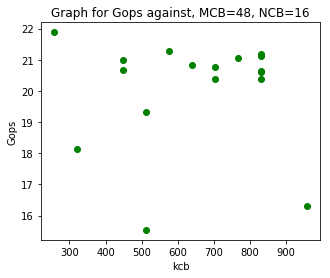

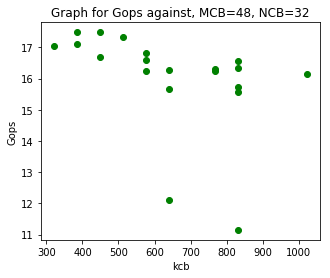

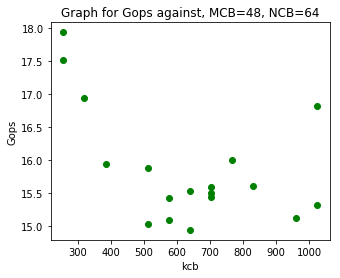

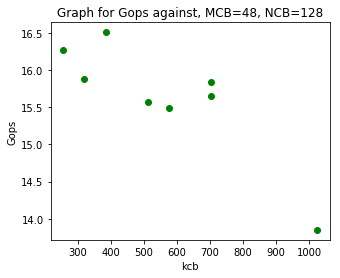

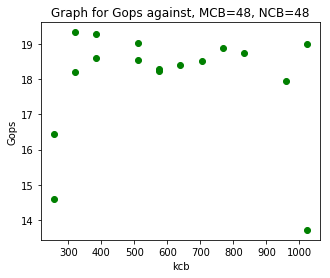

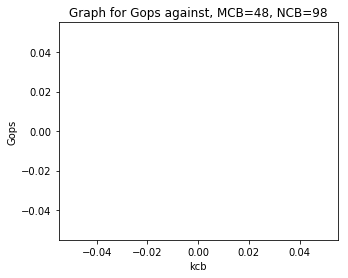

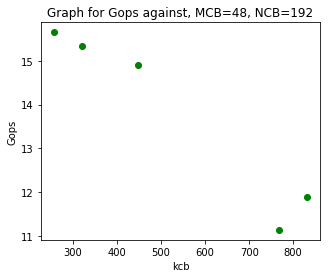

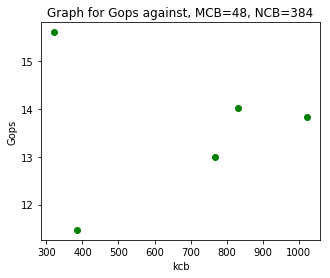

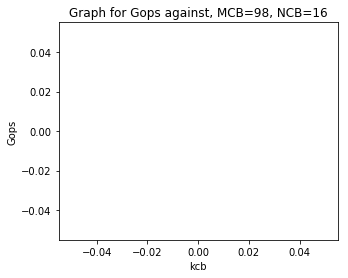

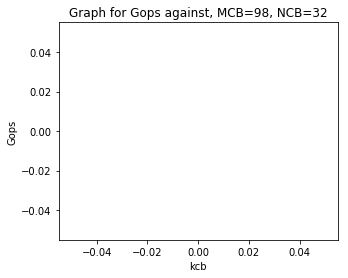

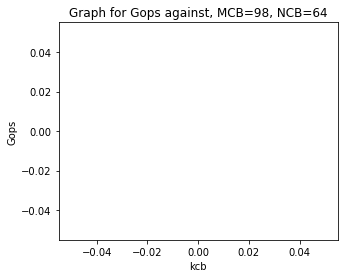

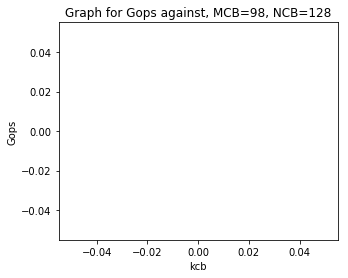

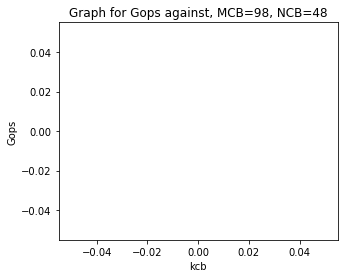

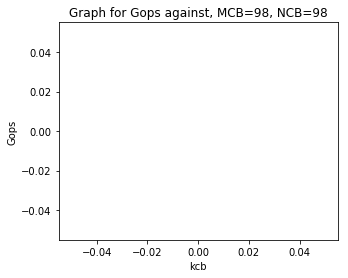

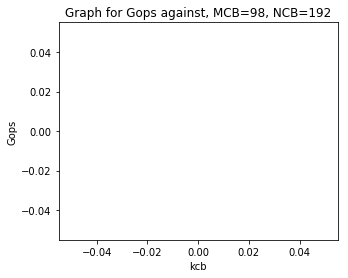

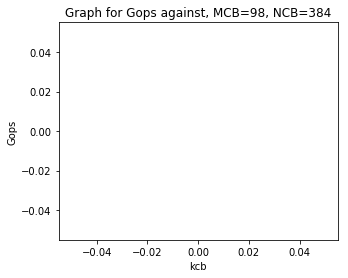

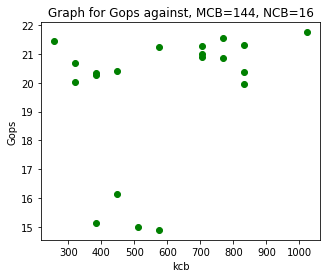

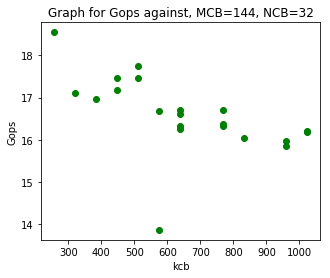

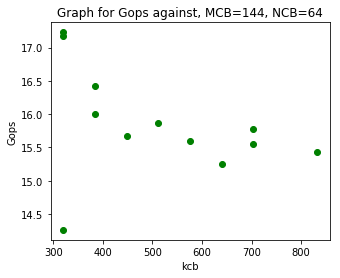

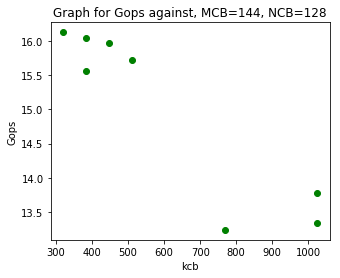

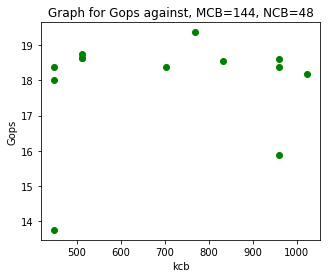

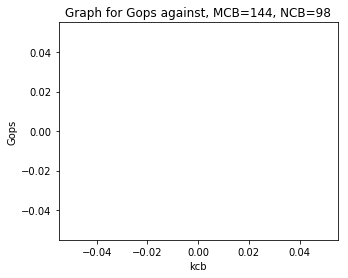

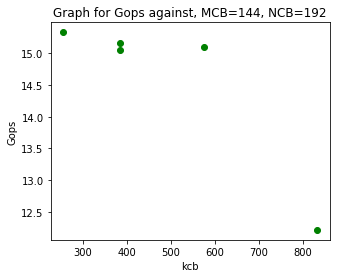

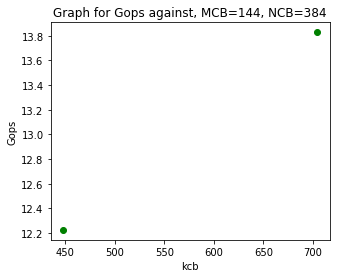

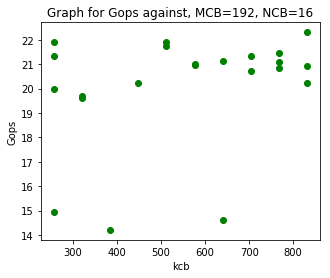

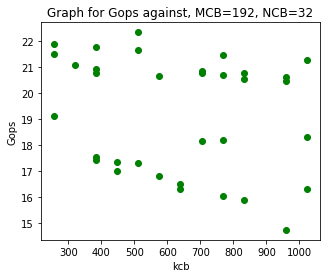

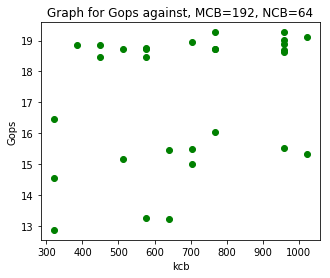

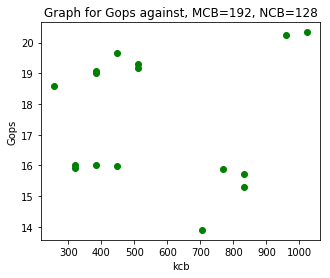

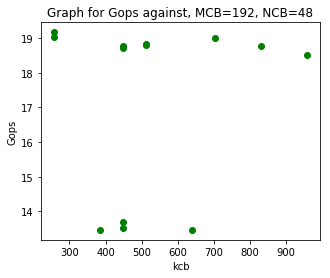

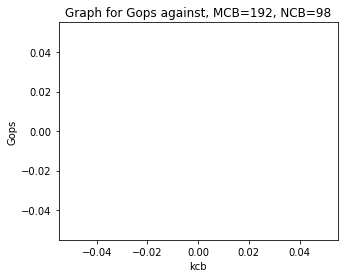

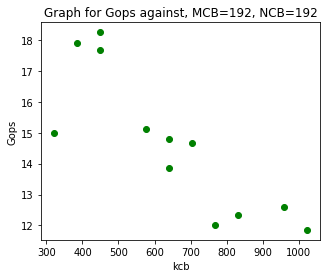

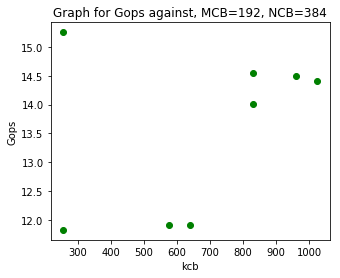

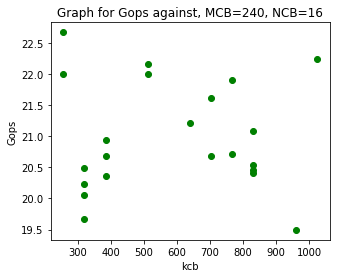

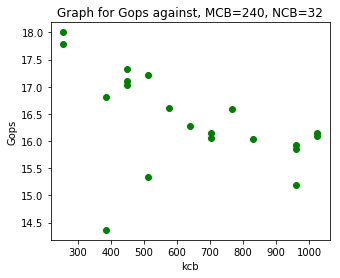

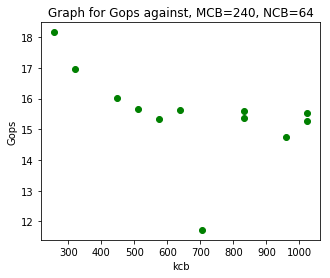

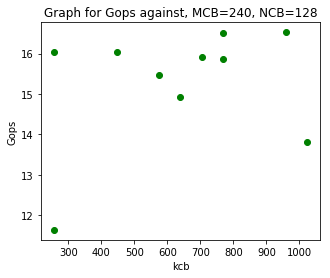

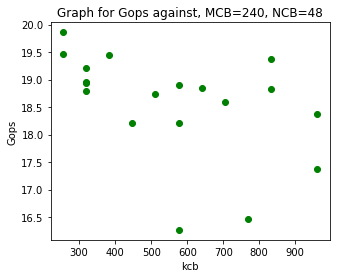

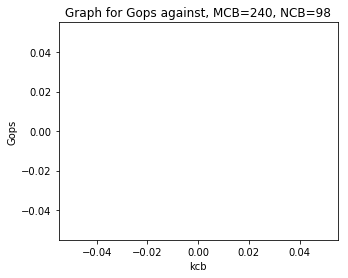

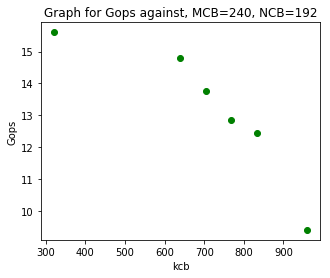

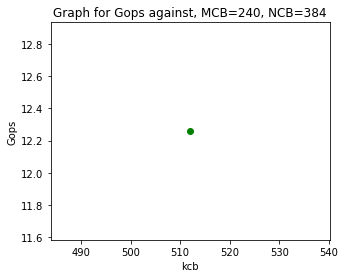

In [144]:
MCBs = [48, 98, 144, 192, 240]
NCBs = [16, 32, 64, 128, 48, 98, 192, 384]
KCBs = [256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 960, 1024]
MRs = [24, 12, 6, 3, 8, 4, 2, 1]
NRs = [16, 32]

for mcb in MCBs:
    for ncb in NCBs:
        plot_fix_mcb_ncb_kcb_effectof(mcb, ncb)

## 4. Visualizing high dimensional data - All at once!

Finally, here comes the really exciting part!! Thanks to amazing Protonu's amazing friend (thanks, friend!), who reveals the existence of Advanced Parallel Coordinates Plot in plotly, we can visualize the effect of 5-dim data on Gops all at once. 

How does the graph work? In the graph below, each vertical line represents one dimension, i.e. one of MCB, NCB, KCB, MR and NR. For each configuration, which is essentially a tuple of (MCB, NCB, KCB, MR, NR), we use a zigzag line to connect values on the axises together. That line represents a data point for one particular configuration. Yet how to represent Gops? By the color of the line! On the rightmost side, it indicates what color corresponds to higher/lower value. Intuitively red lines represents higher Gops and blue lines represents lower Gops.

We can see that the resulting visualization corresponds to our analysis in part 3 above - In the first axis for MCB, the distributions according to changes in other parameters are similar. In the second axis for NCB, lower NCB performs significantly better than higher NCB, etc. There can be much more interesting work done by visualizing high dimensional data later on! :)

In [145]:
import plotly

# You will have to register for an account for plotly, which is free for 25 plots / month.
#plotly.tools.set_credentials_file(username='huihanl', api_key='')

In [146]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd 

df = new_config_lst
df['Gops'] = np.log10(df['Gops'])

mcb_max = df['mcb'].max()
mcb_min = df['mcb'].min()

ncb_max = df['ncb'].max()
ncb_min = df['ncb'].min()

kcb_max = df['kcb'].max()
kcb_min = df['kcb'].min()

mr_max = df['mr'].max()
mr_min = df['mr'].min()

nr_max = df['nr'].max()
nr_min = df['nr'].min()

Gops_max = df['Gops'].max()
Gops_min = df['Gops'].min()

In [147]:
data = [
    go.Parcoords(
        line = dict(color = df['Gops'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = False,
                   cmin = Gops_min,
                   cmax = Gops_max),
        dimensions = list([
            dict(range = [mcb_min,mcb_max],
                 #constraintrange = [100000,150000],
                 label = 'MCB', values = df['mcb']),
            dict(range = [ncb_min,ncb_max],
                 label = 'NCB', values = df['ncb']),
            dict(range = [kcb_min,kcb_max],
                 label = 'KCB', values = df['kcb']),
            dict(range = [mr_min,mr_max],
                 #tickvals = [0,1,2,3],
                 label = 'MR', values = df['mr']),
            dict(range = [nr_min,nr_max],
                 tickvals = [16, 32],
                 visible = True,
                 label = 'NR', values = df['nr'])
        ])
    )
]

py.iplot(data, filename = 'configuration')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## 5. Other random fun things

### 1) The use of Linear Regression or other higher order modelling techniques

It might be interesting to treat the problem as a regression or model fitting problem, thanks to Di Wu's suggestion, and I think it's an enlightening perspective:

In [148]:
import math
from sklearn.linear_model import LinearRegression
log_Gops = [math.log(i) for i in new_Gops_lst]
# new_config_x = [eval(p[0]) for p in pair] new_Gops_lst = [p[1] for p in pair]
reg = LinearRegression().fit(new_config_x, log_Gops)
score = reg.score(new_config_x, log_Gops)
coef = reg.coef_
interc = reg.intercept_ 
print(score, coef, interc)

0.4076552977140098 [ 1.00341538e-04 -1.11082729e-03 -8.36105536e-05  3.37602688e-03
  6.09274504e-03  0.00000000e+00  0.00000000e+00] 2.830761912745137


### 2) Trend for Gops for each (MR, NR) pair

I plotted the decreasing trend for Gops for each (MR, NR) pair, just like part 1. It can be seen that the three phase transitions are mainly contributed by the (MR, NR) pair that has the most number of valid configurations.

In [149]:
def plot_fix_mr_nr(mr, nr):

    df = new_config_lst
    df = df.loc[(df['mr'] == mr) & (df['nr'] == nr)]
    plt.title('Trend for each fixed MR, NR pair')
    plt.xlabel("configuration index")
    plt.ylabel("Gops")
    plt.plot([i for i in range(df.shape[0])], df["Gops"])

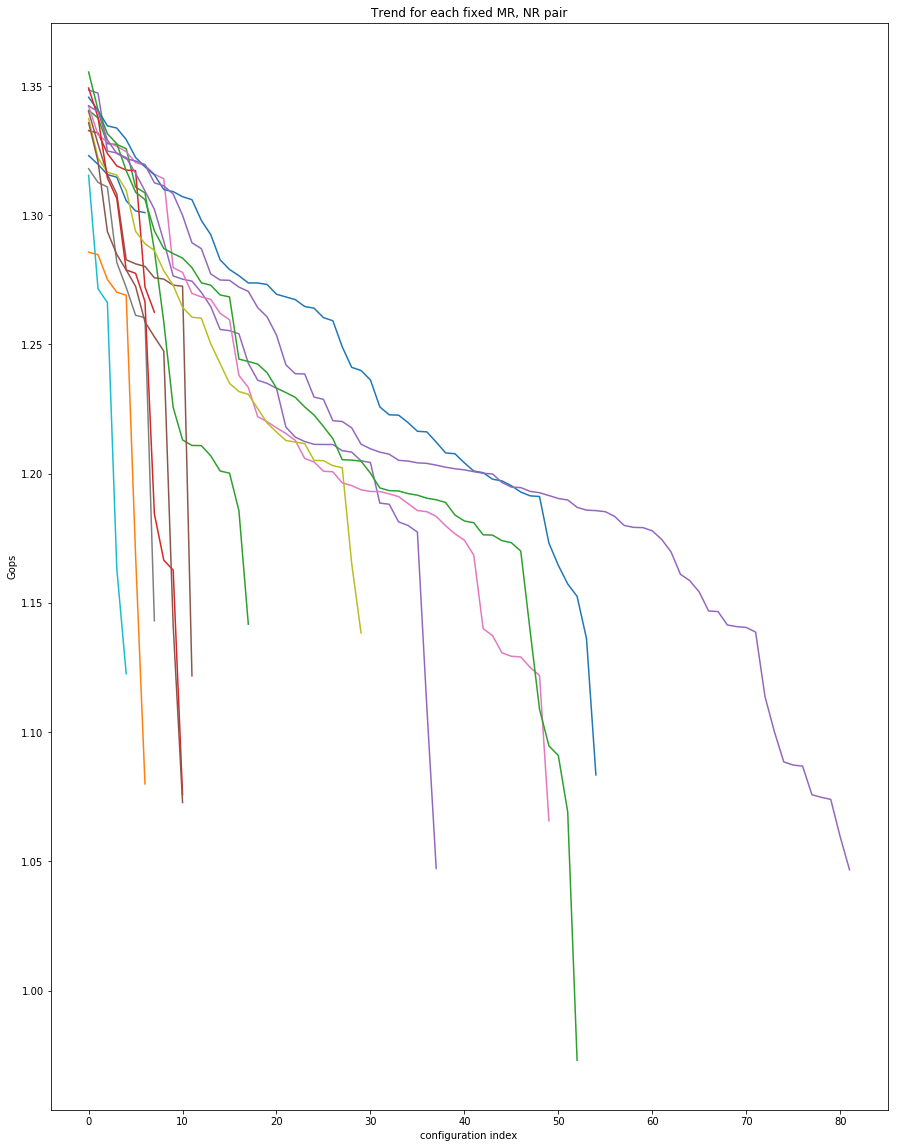

In [150]:
MRs = [24, 12, 6, 3, 8, 4, 2, 1]
NRs = [16, 32]

plt.figure(figsize=(15, 20))
for mr in MRs:
    for nr in NRs:
        plot_fix_mr_nr(mr, nr)